In [224]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel.freesurfer.io as fsio
from nilearn import datasets, plotting
import numpy as np
from matplotlib import cm

In [225]:
df = pd.read_csv('/Users/baileyng/MIND_data/MIND_results/1000177_20263_2_0_aparc_MIND_matrix.csv', index_col=0)

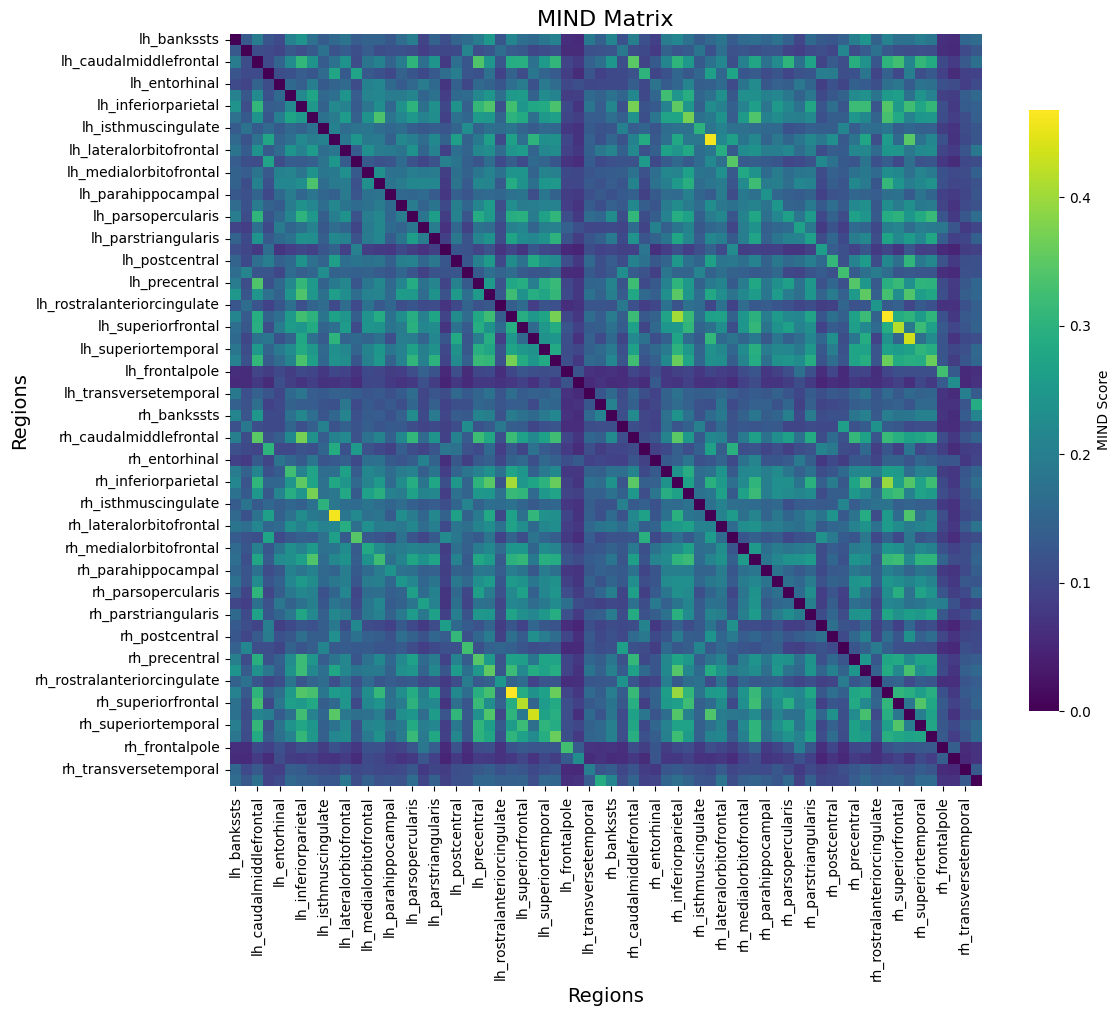

In [226]:
plt.figure(figsize=(12, 10))
sns.heatmap(df,
            cmap='viridis',
            square=True,
            vmin=0,
            cbar_kws={'shrink': 0.8, 'label': 'MIND Score'})

plt.title('MIND Matrix', fontsize=16)
plt.xlabel('Regions', fontsize=14)
plt.ylabel('Regions', fontsize=14)
plt.tight_layout()
plt.show()

In [227]:
avg_df = pd.read_csv('/Users/baileyng/MIND_data/MIND_results/1000177_20263_2_0_aparc_MIND_avg_matrix.csv', index_col=0)

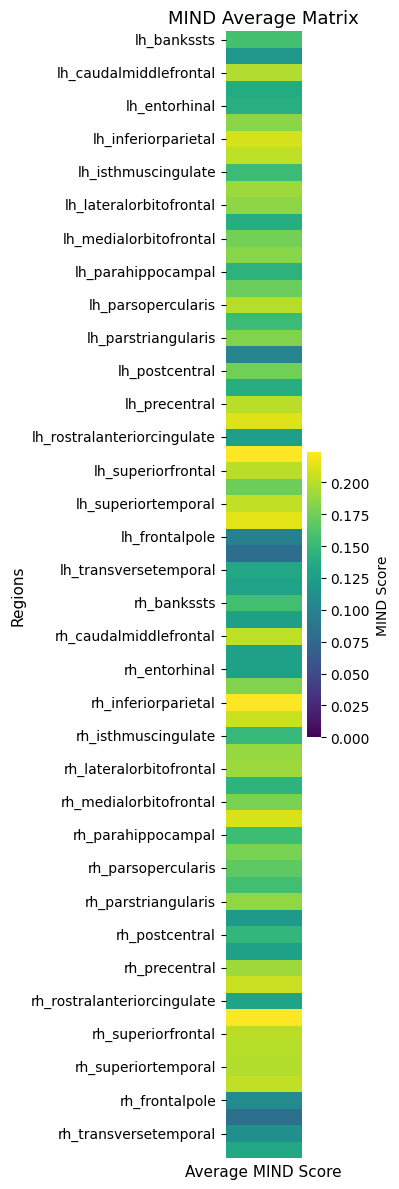

In [228]:
plt.figure(figsize=(4, 12))
sns.heatmap(avg_df,
            cmap='viridis',
            vmin=0,
            xticklabels=False,
            cbar_kws={'shrink': 0.8, 'label': 'MIND Score'})

plt.title('MIND Average Matrix', fontsize=13)
plt.xlabel('Average MIND Score', fontsize=11)
plt.ylabel('Regions', fontsize=11)
plt.tight_layout()
plt.show()

In [229]:
fc_df = pd.read_csv('/Users/baileyng/MIND_data/MIND_results/1000177_25752_2_0_FC_matrix.csv', index_col=0)

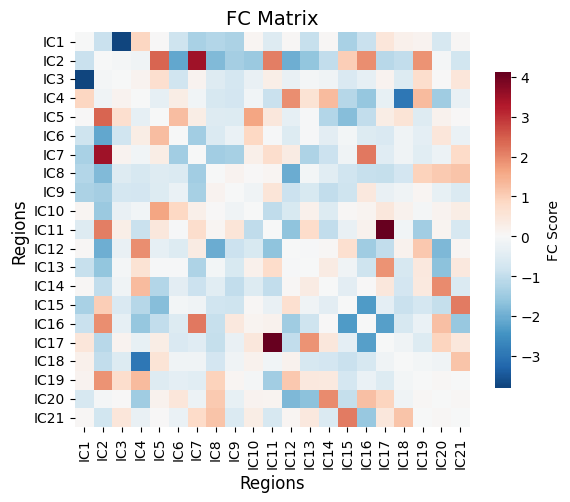

In [230]:
plt.figure(figsize=(6, 5))
sns.heatmap(fc_df,
            cmap='RdBu_r',
            center=0,
            square=True,
            cbar_kws={'shrink': 0.8, 'label': 'FC Score'})

plt.title('FC Matrix', fontsize=14)
plt.xlabel('Regions', fontsize=12)
plt.ylabel('Regions', fontsize=12)
plt.tight_layout()
plt.show()

In [231]:
ct_df = pd.read_csv('/Users/baileyng/MIND_data/ukb_cog/ukb_master_allcols_no_outliers.csv')

In [232]:
rename = pd.read_csv('/Users/baileyng/MIND_models/region_names/col_renames.csv')
rename_dict = dict(zip(rename['datafield_code'], rename['datafield_name']))

pt_df = ct_df[ct_df['eid'] == 1000184]
pt_df = pt_df.rename(columns=rename_dict)

In [233]:
with open('/Users/baileyng/MIND_models/region_names/CT_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

brain_regions = [rename_dict[region] for region in brain_regions]

In [234]:
def varname_to_region(var):
    if var.startswith('lh_'):
        return 'lh', var.replace('lh_', '').replace('_thickness', '')
    elif var.startswith('rh_'):
        return 'rh', var.replace('rh_', '').replace('_thickness', '').replace('.', '')
    return None, None

# 2. Set FreeSurfer fsaverage path
fsaverage_path = '/Applications/freesurfer/subjects/fsaverage'

# 3. Load annotation files
lh_annot = fsio.read_annot(f'{fsaverage_path}/label/lh.aparc.annot')
rh_annot = fsio.read_annot(f'{fsaverage_path}/label/rh.aparc.annot')
lh_labels, lh_cmap, lh_names = lh_annot
rh_labels, rh_cmap, rh_names = rh_annot
lh_names = [name.decode('utf-8') for name in lh_names]
rh_names = [name.decode('utf-8') for name in rh_names]    



/var/folders/kb/ln31wlhj2hb0n089p20hvk9r0000gn/T/ipykernel_31088/1315650008.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


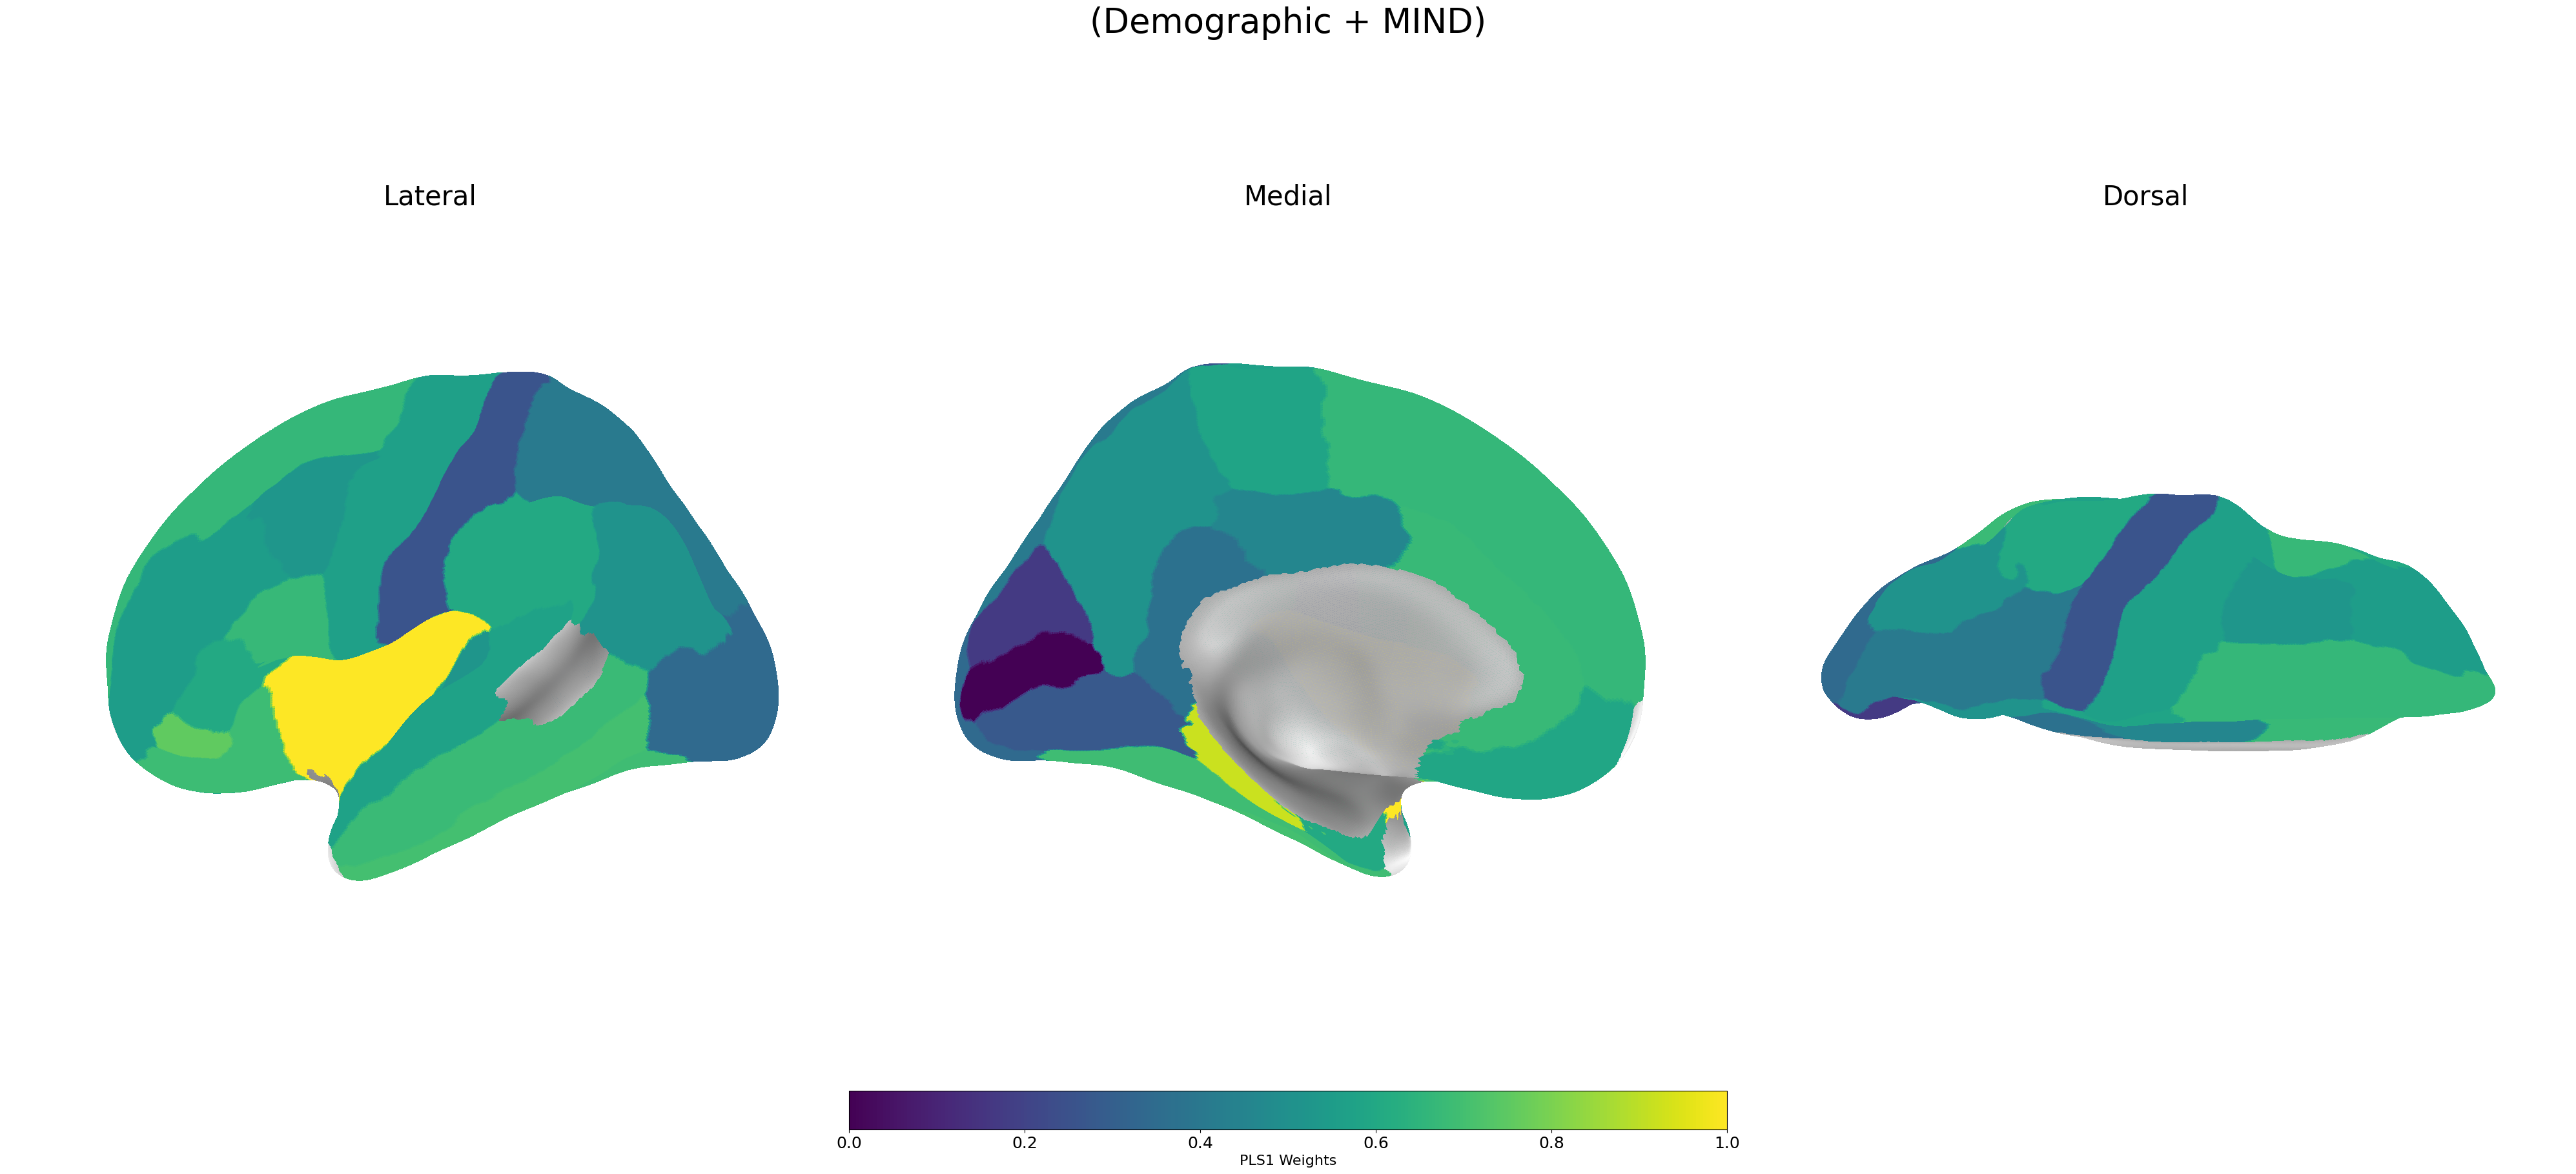

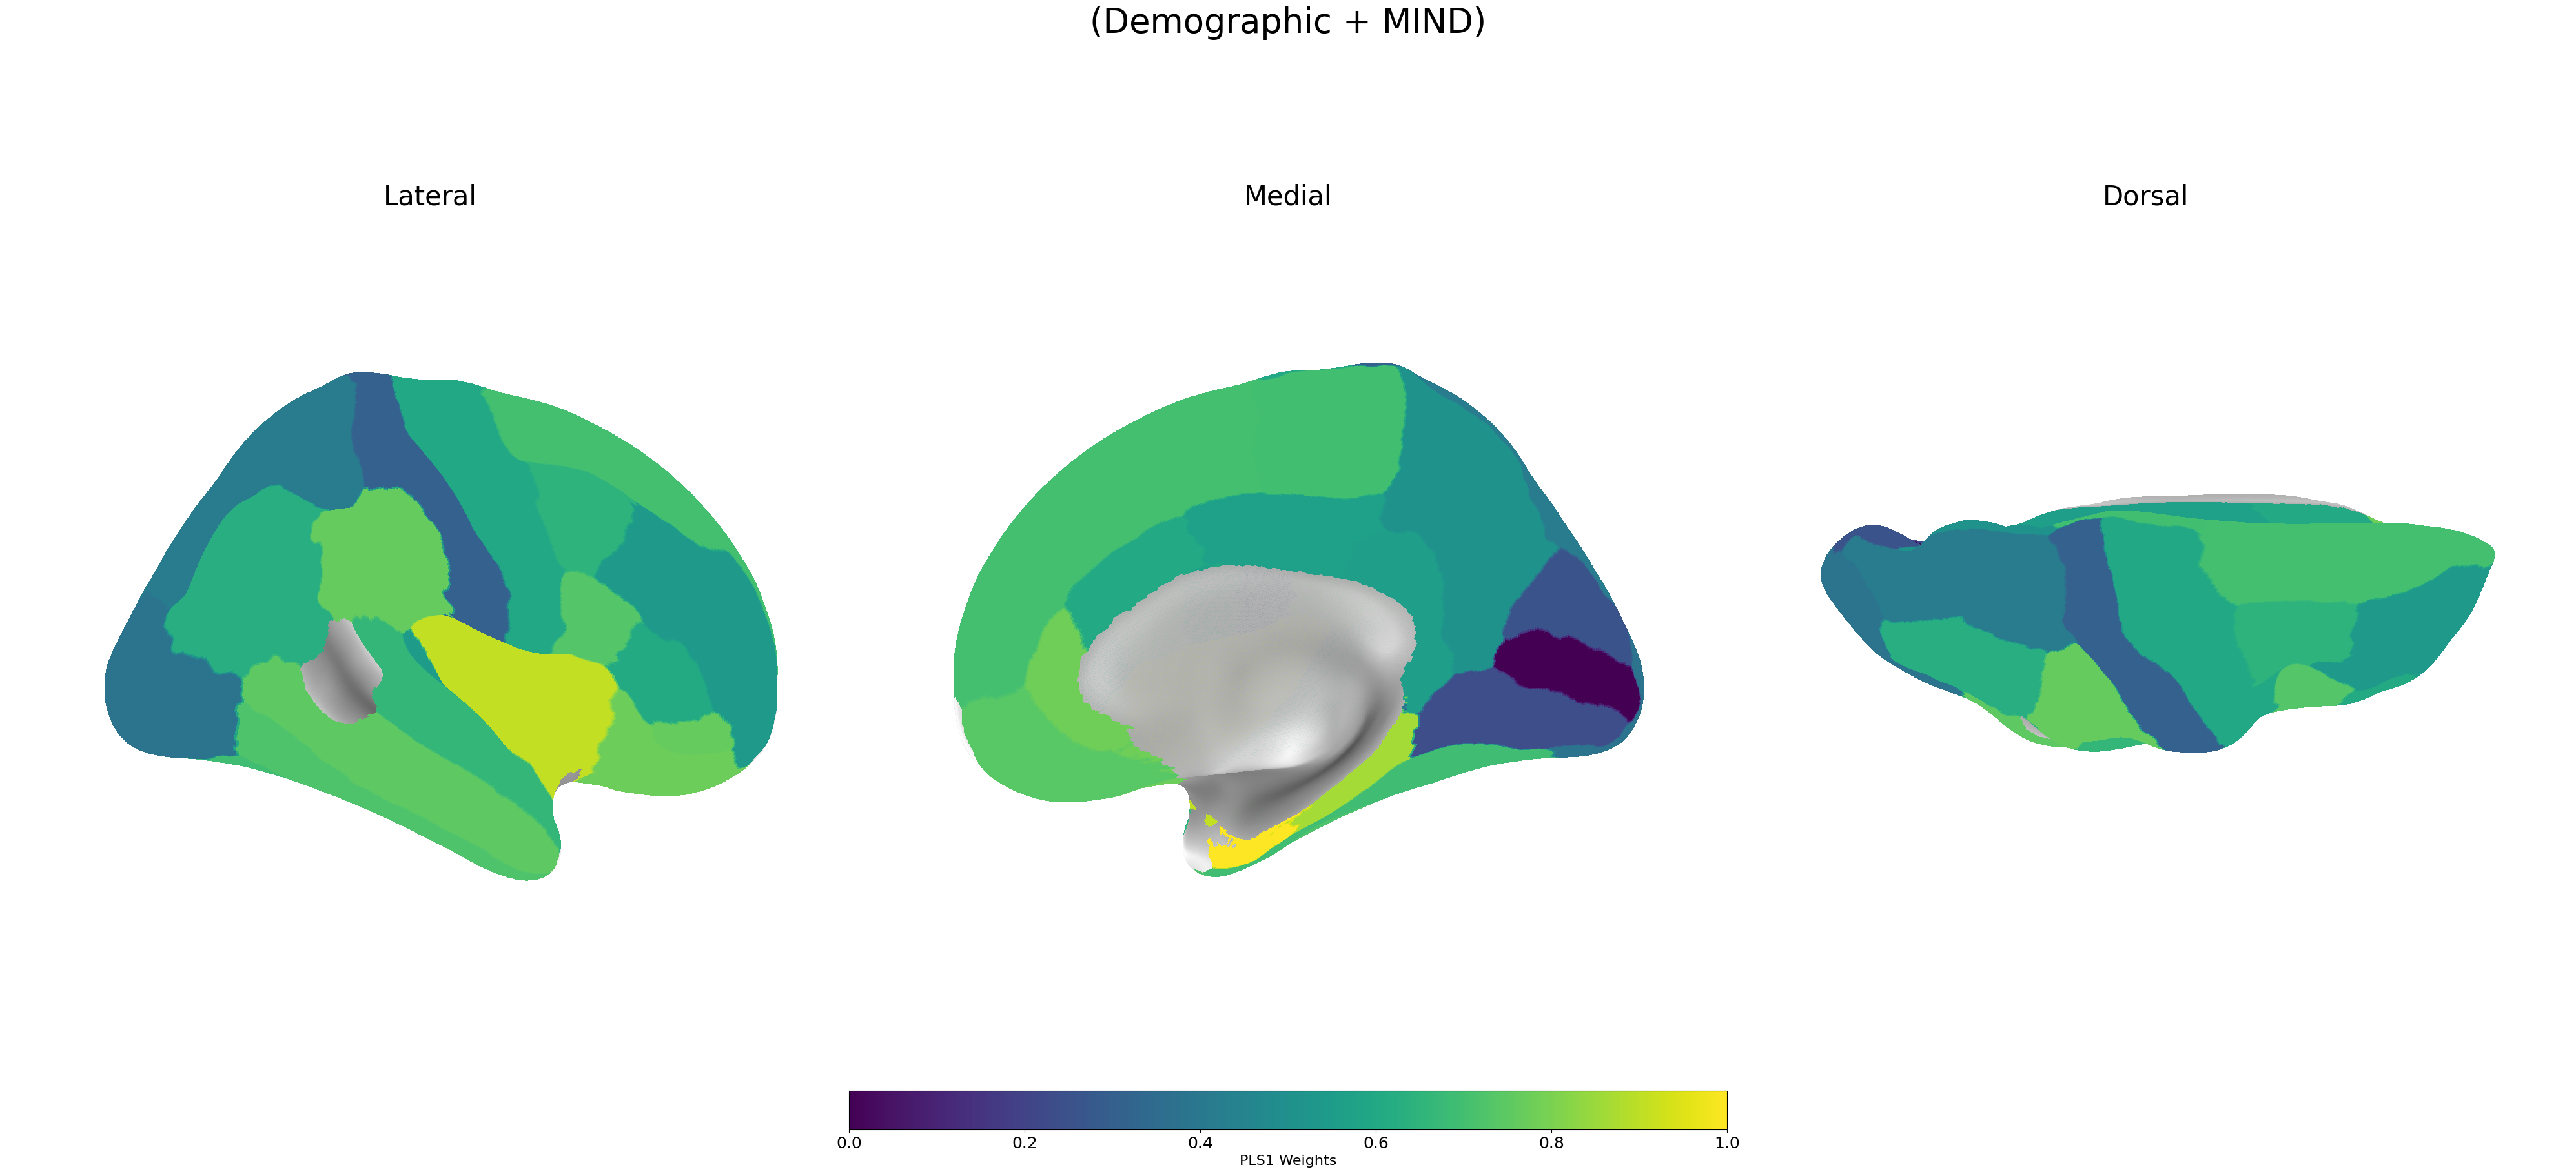

In [241]:
# 1. Variable names and coefficients
vars_to_plot = brain_regions
means = pt_df[vars_to_plot].values.flatten()

# 4. Prepare vertex data arrays
lh_vertex_data = np.full_like(lh_labels, np.nan, dtype=float)
rh_vertex_data = np.full_like(rh_labels, np.nan, dtype=float)

for var, coef in zip(vars_to_plot, means):
    hemi, region = varname_to_region(var)
    if hemi == 'lh':
        idxs = [i for i, n in enumerate(lh_names) if region.lower() in n.lower()]
        for idx in idxs:
            lh_vertex_data[lh_labels == idx] = coef
    elif hemi == 'rh':
        idxs = [i for i, n in enumerate(rh_names) if region.lower() in n.lower()]
        for idx in idxs:
            rh_vertex_data[rh_labels == idx] = coef

# 5. Load inflated_pre surfaces
lh_inflated_pre_path = f'{fsaverage_path}/surf/lh.inflated_pre'
rh_inflated_pre_path = f'{fsaverage_path}/surf/rh.inflated_pre'
lh_coords, lh_faces = fsio.read_geometry(lh_inflated_pre_path)
rh_coords, rh_faces = fsio.read_geometry(rh_inflated_pre_path)
lh_mesh = (lh_coords, lh_faces)
rh_mesh = (rh_coords, rh_faces)

# 6. Load fsaverage sulcal maps for background
fsavg = datasets.fetch_surf_fsaverage('fsaverage')
sulc_left = fsavg.sulc_left
sulc_right = fsavg.sulc_right

# 7. Plotting function
def plot_three_views_custom(surf_mesh, vertex_data, bg_map, hemi, title):
    views = ['lateral', 'medial', 'dorsal']
    fig, axes = plt.subplots(1, 3, subplot_kw={'projection': '3d'}, figsize=(40, 20))
    cmap = 'viridis'
    for i, view in enumerate(views):
        plotting.plot_surf_stat_map(
            surf_mesh, vertex_data, hemi=hemi, bg_map=bg_map,
            cmap=cmap, colorbar=False, symmetric_cbar=False,
            view=view, axes=axes[i], title='', figure=fig, alpha=0.9
        )
        axes[i].set_title(view.capitalize(), fontsize=30)
        axes[i].axis('off')
    # Colorbar
    cbar_ax = fig.add_axes([0.33, 0.09, 0.34, 0.03])
    norm = plt.Normalize()
    cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax, orientation='horizontal')
    cb.set_label('PLS1 Weights', fontsize=16)
    cb.ax.tick_params(labelsize=18)
    plt.suptitle(title, fontsize=38, y=0.96)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# 8. Plot with inflated_pre
plot_three_views_custom(lh_mesh, lh_vertex_data, sulc_left, 'left', '(Demographic + MIND)')
plot_three_views_custom(rh_mesh, rh_vertex_data, sulc_right, 'right', '(Demographic + MIND)')